In [1]:
import re
import os
import sys
import datetime
import itertools
import math
from matplotlib.pylab import rcParams
import pandas as pd
import numpy as np
pd.options.display.max_columns = 16
pd.options.display.max_rows = 16
pd.set_option('display.float_format', lambda x: '%.5f' % x)
np.set_printoptions(precision=5, suppress=True)
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
plt.rcParams['savefig.dpi'] = 120
plt.rcParams['figure.figsize'] = (10, 4)
#plt.rcParams['font.family'] = "serif"
#plt.rcParams['font.serif'] = "cm"
plt.rcParams['text.latex.preamble'] = b"\usepackage{subdepth}, \usepackage{type1cm}"
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from ipywidgets import interactive, widgets, RadioButtons, ToggleButtons, Select, FloatSlider, FloatProgress
from IPython.display import set_matplotlib_formats, Image
from datetime import datetime
from statsmodels.tsa.stattools import adfuller, kpss	
from math import sqrt
from sklearn.metrics import mean_squared_error

#serie de tiempo en grafico
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')

#leer la data del excel de los huespedes.csv
data = pd.read_csv('./data/hotelguests.csv', parse_dates=['time'], index_col='time',date_parser=dateparse)

#guardar en otra variable
ts = data['#guests']

#imprimir la serie de tiempo y guardarla en la carpeta imagen como referencia
plt.plot(data)
plt.title('Reserva de habitaciones Hotel los Cocos', fontsize=16)
plt.ylabel('# habitaciones')
plt.xlabel('Año')
plt.savefig('./img/serie_huespedes.png')
plt.show()

<Figure size 1000x400 with 1 Axes>

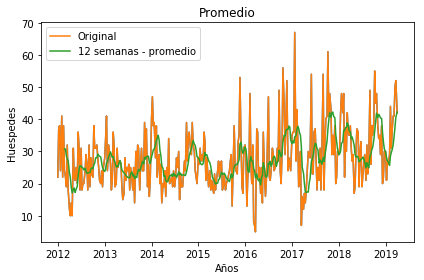

In [2]:

plt.plot(data)
plt.plot(ts.index, ts, label='Original');
plt.plot(ts.index, ts.rolling(window=8).mean(), label='12 semanas - promedio');
plt.xlabel("Años");
plt.ylabel("Huespedes");
plt.title("Promedio");
plt.legend(loc='best');
plt.tight_layout();
plt.savefig('./img/tendencia.png')
plt.show()

In [3]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
df = pd.read_csv('./data/hotelguests.csv', parse_dates=['time'], index_col='time',date_parser=dateparse)


In [4]:
y = data['#guests']
def adf_test(y):
    print('Resultados de prueba de Augmented Dickey-Fuller:')
    dftest = adfuller(y, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Estadistico de prueba', 'p-value', '# de retrasos', '# de observaciones'])
    for key, value in dftest[4].items():
        dfoutput['Valor critico ({})'.format(key)] = value
    print(dfoutput)
adf_test(y)    

Resultados de prueba de Augmented Dickey-Fuller:
Estadistico de prueba    -6.68622
p-value                   0.00000
# de retrasos             2.00000
# de observaciones      346.00000
Valor critico (1%)       -3.44939
Valor critico (5%)       -2.86993
Valor critico (10%)      -2.57124
dtype: float64


In [5]:
#prediccion SARIMA
# Dividir data en entrenamiento y prueba
y = df['#guests']
y_train = y[:'2018']
y_test = y['2019':]
print('Prueba', len(y_test))
print(y_test)
print('Entrenamiento', len(y_train))
print(y_train)

Prueba 13
time
2019-01-01    30
2019-01-08    21
2019-01-15    27
2019-01-22    26
2019-02-01    29
2019-02-08    44
2019-02-15    31
2019-02-22    37
2019-03-01    41
2019-03-08    41
2019-03-15    50
2019-03-22    52
2019-04-01    42
Name: #guests, dtype: int64
Entrenamiento 336
time
2012-01-01    22
2012-01-08    37
2012-01-15    38
2012-01-22    24
2012-02-01    41
2012-02-08    22
2012-02-15    38
2012-02-22    24
              ..
2018-11-01    38
2018-11-08    34
2018-11-15    35
2018-11-22    29
2018-12-01    38
2018-12-08    20
2018-12-15    22
2018-12-22    30
Name: #guests, Length: 336, dtype: int64


In [6]:
# Definir p, d y q parametros entre 0 y 2
p = d = q = range(0, 2)

# generar todas las poisibles combinaciones
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
seasonal_pdq

[(0, 0, 0, 12),
 (0, 0, 1, 12),
 (0, 1, 0, 12),
 (0, 1, 1, 12),
 (1, 0, 0, 12),
 (1, 0, 1, 12),
 (1, 1, 0, 12),
 (1, 1, 1, 12)]

In [7]:
best_aic = np.inf
best_pdq = None
best_seasonal_pdq = None
tmp_model = None
best_mdl = None

#calculo de la mejor sarimax
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            tmp_mdl = sm.tsa.statespace.SARIMAX(y_train,
                                             order = param,
                                             seasonal_order = param_seasonal,
                                             enforce_stationarity=True,
                                             enforce_invertibility=True)
            res = tmp_mdl.fit()

#             print("SARIMAX{}x{}12 - AIC:{}".format(param, param_seasonal, results.aic))
            if res.aic < best_aic:
                best_aic = res.aic
                best_pdq = param
                best_seasonal_pdq = param_seasonal
                best_mdl = tmp_mdl
        except:
            print("Unexpected error:", sys.exc_info()[0])
            continue
print("Best SARIMAX{}x{}12 model - AIC:{}".format(best_pdq, best_seasonal_pdq, best_aic))



C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so wi

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so wi

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Best SARIMAX(1, 0, 1)x(0, 1, 1, 12)12 model - AIC:2339.940016449836


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


2339.940016449836
                                 Statespace Model Results                                 
Dep. Variable:                            #guests   No. Observations:                  336
Model:             SARIMAX(1, 0, 1)x(0, 1, 1, 12)   Log Likelihood               -1165.970
Date:                            Sun, 16 Jun 2019   AIC                           2339.940
Time:                                    11:15:43   BIC                           2355.063
Sample:                                         0   HQIC                          2345.976
                                            - 336                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7447      0.095      7.813      0.000       0.558       0.932
ma.L1         -0.

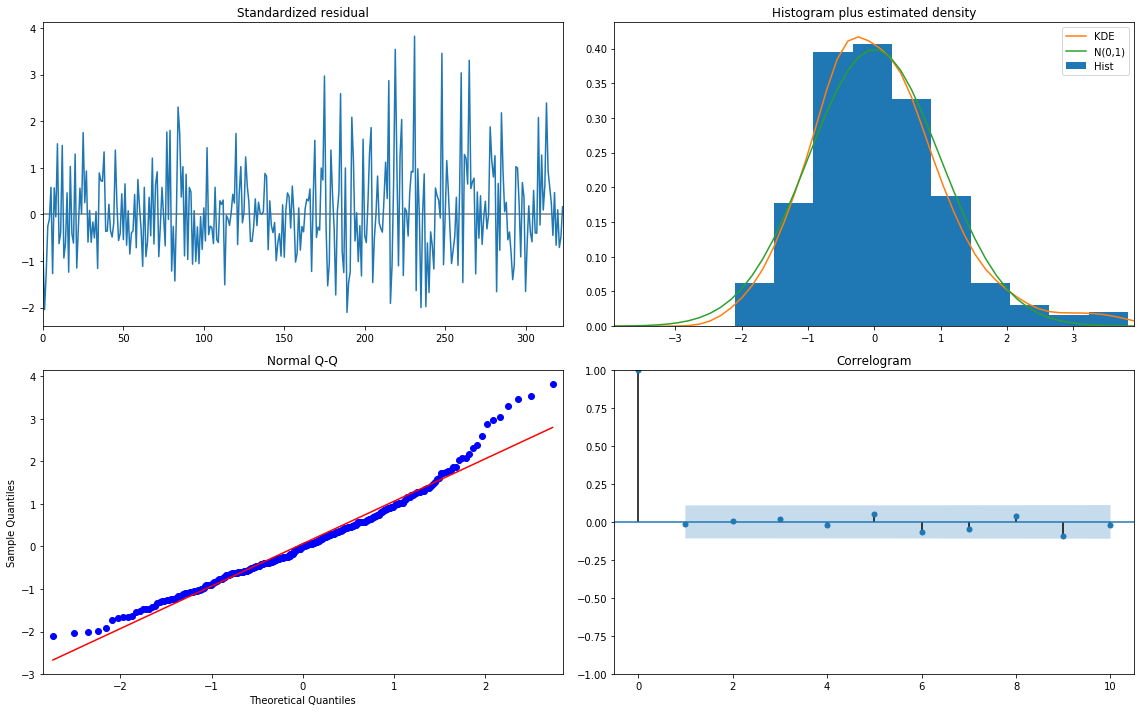

In [8]:
# Definir el modelo sarimax y evaluacion
mdl = sm.tsa.statespace.SARIMAX(y_train,
                                order=(1, 0, 1),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_stationarity=True,
                                enforce_invertibility=True)
res = mdl.fit()

#Estadisticos de prueba
print(res.aic)
print(res.summary())

from scipy.stats import chi2
chi = chi2.isf(q=0.05, df=116)

#chi cuadrado
print(chi)
res.plot_diagnostics(figsize=(16, 10))
plt.tight_layout()
plt.show()

In [9]:
from scipy.stats import chi2
chi = chi2.isf(q=0.05, df=116)
chi

142.13816003902645

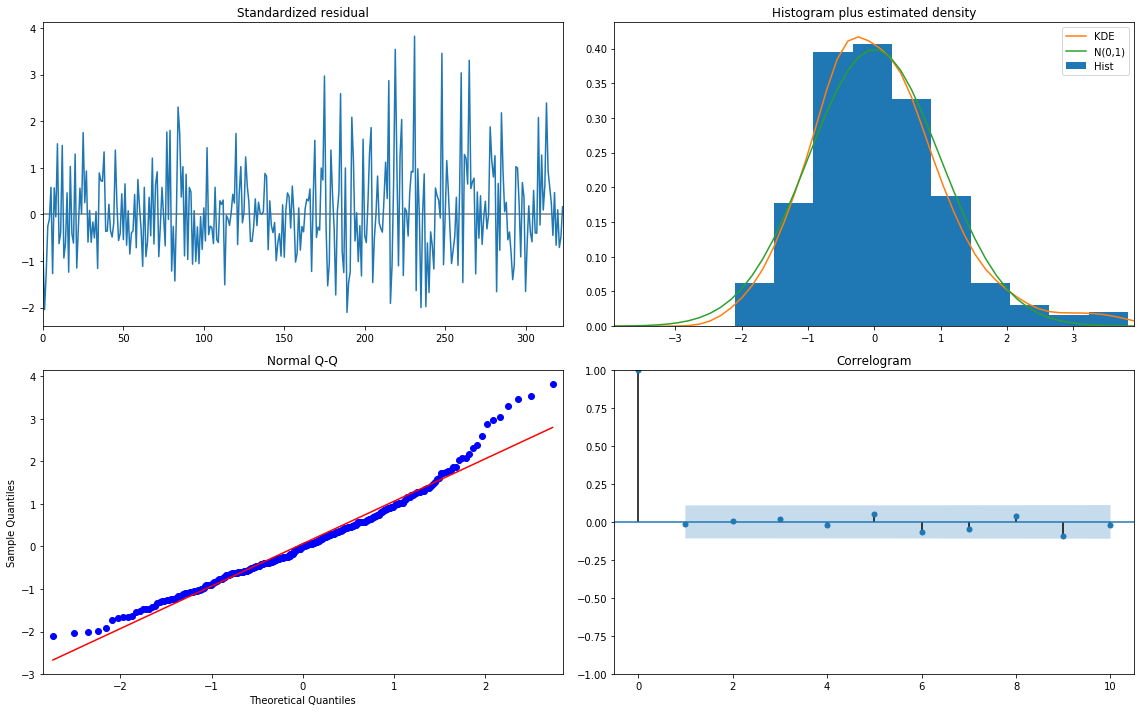

In [10]:
#Graficos de estadisticos
res.plot_diagnostics(figsize=(16, 10))
plt.tight_layout()
plt.savefig('./img/arima_resid.png')
plt.show()

In [11]:
# Entranamiento del modelo
res = sm.tsa.statespace.SARIMAX(y_train,
                                order=(0, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=True,
                                enforce_invertibility=True).fit()

#Prediccion data prueba
pred = res.get_prediction(start=337, 
                          end=349,
                          dynamic=True)

#Muestra de resultados
prediction = list(map(lambda x: int(x), pred.predicted_mean))
print(y_test)
print(prediction)



C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


time
2019-01-01    30
2019-01-08    21
2019-01-15    27
2019-01-22    26
2019-02-01    29
2019-02-08    44
2019-02-15    31
2019-02-22    37
2019-03-01    41
2019-03-08    41
2019-03-15    50
2019-03-22    52
2019-04-01    42
Name: #guests, dtype: int64
[35, 31, 34, 25, 28, 25, 23, 38, 18, 25, 27, 27, 40]


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\kalman_filter.py:1740: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  ' effect.', ValueWarning)


In [12]:
#Calculo del MSE
rms = sqrt(mean_squared_error(y_test, prediction))
print('MSE',rms)
real=np.array(y_test)
print(real)
predi=np.array(prediction)
print(predi)
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

MSE 13.991755814379793
[30 21 27 26 29 44 31 37 41 41 50 52 42]
[35 31 34 25 28 25 23 38 18 25 27 27 40]
